<a href="https://colab.research.google.com/github/juan-villa02/medical_vqa_vlm/blob/main/code/notebooks/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VQA Model - BERT + ResNet18

## Libraries/Dependencies

In [1]:
# PyTorch framework
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.utils as utils
# Image handling
from PIL import Image
from skimage import transform
# Transformers (Hugginface)
from transformers import AutoTokenizer, BertForQuestionAnswering, VisualBertModel, VisualBertForQuestionAnswering, VisualBertConfig
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Extra dependencies
import json
import os
from tqdm import tqdm
import zipfile

In [2]:
# Set training device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Paths & Data Extraction

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path_dir = '.'
path_dir = '/content/drive/MyDrive/TFG Juan Villanueva/databases_qa.zip'

In [5]:
# Data folder
data_folder = './data/'

In [6]:
# ISIC_2016 database (images)
train_ISIC_path = 'databases_qa/ISIC_2016/images/ISBI2016_ISIC_Part3_Training_Data_orig'
test_ISIC_path = 'bases de datos/ISIC_2016/images/ISBI2016_ISIC_Part1_Test_Data_orig'

In [7]:
# Pizarro database (images)
pizarro_path = 'databases_qa/pizarro/images'

In [8]:
# Function to extract databases from the main zip file
def extract_databases(zip_path, extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

In [9]:
# Extract all databases from the main zip file
if path_dir != '.':
  extract_databases(path_dir, data_folder)

In [10]:
# ISIC_2016 images
database1_train_path = os.path.join(data_folder, train_ISIC_path)
database1_test_path = os.path.join(data_folder, test_ISIC_path)

In [11]:
# Pizarro images
# 500 imágenes; Las 46 primeras son más complejas, en cuanto a diagnóstico. (Entrega 1) El resto están más equilibradas (Entrega 2-5)
database2_path = os.path.join(data_folder, pizarro_path)

## VQA Dataset - Images & QA

In [12]:
# Dataset class to load images and questions
class VQADataset(Dataset):
    def __init__(self, data_dir, json_file, tokenizer=None, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.tokenizer = tokenizer

        with open(json_file, 'r') as f:
            self.data = json.load(f)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_path = os.path.join(self.data_dir, item['image_id'])

        # Ensure the image ID ends with ".jpg"
        if not image_path.endswith(".jpg"):
            image_path += ".jpg"

        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Store questions and answers in two different arrays
        qa_pairs = item['qa_pairs']
        questions = [qa['question'] for qa in qa_pairs]
        answers = [qa['answer'] for qa in qa_pairs]

        return image, questions, answers

In [13]:
pizarroDataset = VQADataset(database2_path,'/content/data/databases_qa/pizarro/qa_pizarro.json')

In [14]:
pizarroDataset[10]

(<PIL.Image.Image image mode=RGB size=640x480>,
 ['Can you describe the general silhouette?',
  'How would you characterize the overall silhouette?',
  'What is the overall shape of the lesion?',
  'Describe the silhouette of the lesion.',
  'What does the silhouette of the lesion look like?',
  'What is the histology diagnostic?',
  'Could you provide the histological diagnosis?',
  'What does the histology indicate?',
  'Describe the histological diagnosis.',
  'Based on histology, what is the diagnosis?',
  'Can you see any dysplasia?',
  'Is there any evidence of dysplasia?',
  'Do you observe signs of dysplasia?',
  'Describe the presence of dysplasia.',
  'Is dysplasia present in the lesion?',
  'What is the diagnostic impression?',
  'Could you provide your impression of the diagnosis?',
  'What impression do you have regarding the diagnosis?',
  'Describe your overall diagnosis impression.',
  'What are your thoughts on the diagnosis?',
  'What is the diagnostic difficulty?',
 

## Load pre-trained ResNet18

In [15]:
# Load ResNet-18 model from .pth file
def load_resnet(path, optimizer=None, scheduler=None):
    resnet = models.resnet18()
    # Remove final fully connected layer (we do not want the model to return labels but features)
    resnet.fc = nn.Identity()

    # Load the weights
    state_dict = torch.load(path, map_location=device)['state_dict']

    # Remove unexpected keys if they exist
    unexpected_keys = ['fc.weight', 'fc.bias']
    for key in unexpected_keys:
        if key in state_dict:
            del state_dict[key]

    # Load the weights
    resnet.load_state_dict(state_dict)
    resnet.eval()

    if optimizer is not None:
        optimizer.load_state_dict(torch.load(path)['optimizer'])
    if scheduler is not None:
        scheduler.load_state_dict(torch.load(path)['scheduler'])

    resnet.to(device)

    return resnet, optimizer, scheduler

In [16]:
model_source_path = '/content/drive/MyDrive/TFG Juan Villanueva/codigo diagnostico/bestdiagNet.pth'

In [17]:
resnet, optimizer, scheduler = load_resnet(model_source_path)

In [18]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Image Transformations

In [19]:
class Normalize(object):
    """Normalizes the image by subtracting the mean and dividing by the standard deviations.

    Args:
        mean: The vector containing the means.
        std: The vector containing the standard deviations.
    """

    def __init__(self, mean, std):
        assert len(mean) == len(std), 'Length of mean and std vectors is not the same'
        self.mean = np.array(mean)
        self.std = np.array(std)

    def __call__(self, image):

        image = image.float()  # Convert to float tensor
        image = image / 255.0  # Scale pixel values to the range [0, 1]

        dtype = image.dtype
        mean = torch.as_tensor(self.mean, dtype=dtype, device=image.device)
        std = torch.as_tensor(self.std, dtype=dtype, device=image.device)
        # Avoid division by nearly zero
        std[std < 1e-5] = 1.0
        # Normalize the image
        image = (image - mean[:, None, None]) / std[:, None, None]

        return image

In [20]:
class ToTensor(object):
    """Converts the image ndarray to a tensor."""

    def __call__(self, image):
        # Change the axes
        # numpy image: H x W x C
        # torch image: C x H x W
        image = np.array(image)
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image)

        return image


In [21]:
class Rescale(object):
    """Rescales the image to a desired size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is the output_size.
            If int, the smaller of the image edges is matched to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        # Convert the PIL image to a NumPy array
        image_np = np.array(image)

        # Get the height and width of the image
        h, w = image_np.shape[:2]

        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        # Resize the image using scikit-image's resize function
        resized_image = transform.resize(image_np, (new_h, new_w))

        # Convert the resized NumPy array back to a PIL image
        resized_image_pil = Image.fromarray((resized_image * 255).astype(np.uint8))

        return resized_image_pil

## Datasets and Dataloaders

In [22]:
# Train ISIC Dataset------------------------------------------------------------
train_dataset_isic = VQADataset(data_dir=database1_train_path,
                           json_file='/content/data/databases_qa/ISIC_2016/qa_ISIC.json',
                           tokenizer=None,
                           transform=transforms.Compose([
                            Rescale((224,224)),
                            ToTensor(),
                            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                            ]))
# Test ISIC Dataset--------------------------------------------------------------
test_dataset_isic = VQADataset(data_dir=database1_test_path,
                           json_file='/content/data/databases_qa/ISIC_2016/qa_ISIC.json',
                           tokenizer=None,
                           transform=transforms.Compose([
                            Rescale((224,224)),
                            ToTensor(),
                            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                            ]))

In [23]:
# Train Pizarro Dataset------------------------------------------------------------
train_dataset_pizarro = VQADataset(data_dir=database2_path,
                           json_file='/content/data/databases_qa/pizarro/qa_pizarro.json',
                           tokenizer=None,
                           transform=transforms.Compose([
                            Rescale((224,380)),
                            ToTensor(),
                            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                            ]))

In [24]:
#train_dataset_pizarro[102]

In [25]:
# Pizarro dataset
pizarro_dataloader = DataLoader(train_dataset_pizarro, batch_size=1, shuffle=True)

In [26]:
# Auxiliary function to visualize a batch
def show_batch(sample_batched):
    """Show a batch of images."""

    # Store images, questions and answers
    images_batch, questions_batch, answers_batch = \
            sample_batched[0], sample_batched[1], sample_batched[2]

    # Identify the batch size to define the grid
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    # Generate the grid
    grid = utils.make_grid(images_batch)

    # Convert to numpy and denormalize
    grid = grid.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    grid = std * grid + mean
    grid = np.clip(grid, 0, 1)
    plt.imshow(grid)
    plt.title('Batch from dataloader')
    plt.axis('off')
    plt.show()

0 [('The general silhouette of the lesion is flattened elevated.',), ('The general silhouette of the lesion is flattened elevated.',), ('The general silhouette of the lesion is flattened elevated.',), ('The general silhouette of the lesion is flattened elevated.',), ('The general silhouette of the lesion is flattened elevated.',), ('The histology diagnostic indicates non-atypical stable mole (m).',), ('The histology diagnostic indicates non-atypical stable mole (m).',), ('The histology diagnostic indicates non-atypical stable mole (m).',), ('The histology diagnostic indicates non-atypical stable mole (m).',), ('The histology diagnostic indicates non-atypical stable mole (m).',), ('The presence of dysplasia is not applicable.',), ('The presence of dysplasia is not applicable.',), ('The presence of dysplasia is not applicable.',), ('The presence of dysplasia is not applicable.',), ('The presence of dysplasia is not applicable.',), ('The diagnostic impression is non-atypical mole.',), ('T

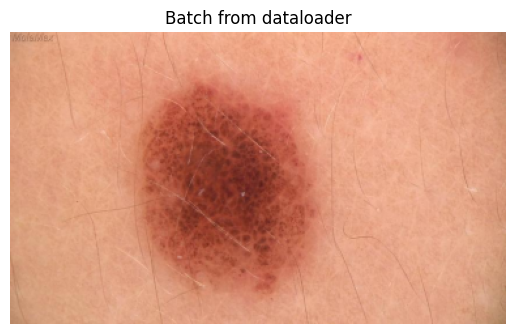

1 [('The general silhouette of the lesion is flat.',), ('The general silhouette of the lesion is flat.',), ('The general silhouette of the lesion is flat.',), ('The general silhouette of the lesion is flat.',), ('The general silhouette of the lesion is flat.',), ('The histology diagnostic indicates non-atypical stable mole (m).',), ('The histology diagnostic indicates non-atypical stable mole (m).',), ('The histology diagnostic indicates non-atypical stable mole (m).',), ('The histology diagnostic indicates non-atypical stable mole (m).',), ('The histology diagnostic indicates non-atypical stable mole (m).',), ('The presence of dysplasia is not applicable.',), ('The presence of dysplasia is not applicable.',), ('The presence of dysplasia is not applicable.',), ('The presence of dysplasia is not applicable.',), ('The presence of dysplasia is not applicable.',), ('The diagnostic impression is non-atypical mole.',), ('The diagnostic impression is non-atypical mole.',), ('The diagnostic im

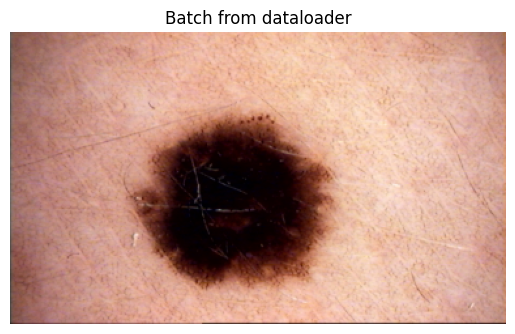

In [27]:
# Iterate over the dataloader and visualize batches
for i_batch, sample_batched in enumerate(pizarro_dataloader):
    print(i_batch, sample_batched[2])
    show_batch(sample_batched)

    # Show only the data of the 3rd batch and stop.
    if i_batch == 1:
        break

## Image Feature Extraction

In [28]:
def extract_image_features(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    num_samples = len(dataloader.dataset)

    # Get the output shape of the model
    with torch.no_grad():
        sample_input = next(iter(dataloader))[0].to(next(model.parameters()).device)
        output_shape = model(sample_input).shape[1:]

    # Calculate the total number of features
    num_features = np.prod(output_shape)

    features = np.zeros((num_samples, num_features), dtype=np.float32)
    sample_idx = 0

    with torch.no_grad():
        for sample in dataloader:
            # Get images
            inputs = sample[0].to(device).float()

            # Forward pass
            outputs = model(inputs)

            # Flatten the output tensor
            outputs_flat = outputs.view(outputs.size(0), -1)

            # Store features
            batch_size = inputs.size(0)
            features[sample_idx:sample_idx + batch_size, :] = outputs_flat.cpu().numpy()
            sample_idx += batch_size

    return torch.tensor(features, device=device)

In [29]:
features_pizarro = extract_image_features(resnet, pizarro_dataloader)

In [30]:
features_pizarro

tensor([[1.6084, 0.3438, 0.1257,  ..., 1.9227, 0.9830, 0.4359],
        [0.2237, 0.2682, 0.0313,  ..., 1.3180, 0.9367, 0.5781],
        [0.0589, 0.4432, 1.5715,  ..., 0.8823, 0.7326, 0.6750],
        ...,
        [0.3058, 0.2297, 0.0168,  ..., 0.1847, 0.2610, 0.3217],
        [0.4107, 0.5986, 0.5199,  ..., 0.9449, 1.1791, 0.4224],
        [1.1466, 0.1763, 0.4718,  ..., 1.9463, 0.9021, 0.8919]],
       device='cuda:0')

In [31]:
features_pizarro[1].size()

torch.Size([512])

In [32]:
images, questions, answers = next(iter(pizarro_dataloader))
print(images.size())
print(np.shape(np.transpose(questions)))
print(np.transpose(questions))

torch.Size([1, 3, 224, 380])
(1, 110)
[['Can you describe the general silhouette?'
  'How would you characterize the overall silhouette?'
  'What is the overall shape of the lesion?'
  'Describe the silhouette of the lesion.'
  'What does the silhouette of the lesion look like?'
  'What is the histology diagnostic?'
  'Could you provide the histological diagnosis?'
  'What does the histology indicate?'
  'Describe the histological diagnosis.'
  'Based on histology, what is the diagnosis?'
  'Can you see any dysplasia?' 'Is there any evidence of dysplasia?'
  'Do you observe signs of dysplasia?'
  'Describe the presence of dysplasia.'
  'Is dysplasia present in the lesion?'
  'What is the diagnostic impression?'
  'Could you provide your impression of the diagnosis?'
  'What impression do you have regarding the diagnosis?'
  'Describe your overall diagnosis impression.'
  'What are your thoughts on the diagnosis?'
  'What is the diagnostic difficulty?'
  'How challenging is the diagnosi

## VQA Model Creation

In [50]:
class VQAModel(nn.Module):
    def __init__(self, resnet, vlm, tokenizer):
        super(VQAModel, self).__init__()

        # Pre-trained ResNet model
        self.resnet = resnet
        # Vision Language Model
        self.vlm = vlm
        # Tokenizer
        self.tokenizer = tokenizer
        # Freeze parameters of the ResNet model
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Additional layers for VQA
        #self.fc = nn.Linear(512 + self.vlm.config.hidden_size, 1)

    def forward(self, images, questions, dataloader):

        # Transpose questions (DataLoader returns shape (110,20) instead of (20,110))
        questions = np.transpose(questions)
        num_images, num_questions_per_image = np.shape(questions)

        # Extract image features
        with torch.no_grad():
            image_features = extract_image_features(self.resnet, dataloader)

        # Prepare image inputs
        visual_token_type_ids = torch.ones(image_features.shape[:-1], dtype=torch.long, device=device)
        visual_attention_mask = torch.ones(image_features.shape[:-1], dtype=torch.float, device=device)

        # Tokenize questions for each image
        inputs = []
        for image_idx in range(num_images):
          tokenized_questions = []
          # Tokenize questions individually
          for question in questions[image_idx]:
            tokenized_question = self.tokenizer(question,
                                                return_token_type_ids=True,
                                                return_attention_mask=True,
                                                add_special_tokens=True,
                                                return_tensors = 'pt')

            # Input for the VLM model
            input_dict = {
                "visual_embeds": image_features[image_idx].unsqueeze(0),
                "visual_token_type_ids": visual_token_type_ids.unsqueeze(0),
                "visual_attention_mask": visual_attention_mask.unsqueeze(0),
                "input_ids": tokenized_question['input_ids'].to(device),
                "token_type_ids": tokenized_question['token_type_ids'].to(device),
                "attention_mask": tokenized_question['attention_mask'].to(device)
            }
            tokenized_questions.append(input_dict)

          inputs.append(tokenized_questions)

        outputs = []
        for tokenized_questions in inputs:
            answers = []
            for input_dict in tokenized_questions:
              #with torch.no_grad():
              output = self.vlm(**input_dict)
              answers.append(output)
            outputs.append(answers)

        return outputs

### Define LLM & Tokenizer

In [34]:
# Pre-trained base case for VQA provided in documentation
# tokenizer = AutoTokenizer.from_pretrained("deepset/bert-base-cased-squad2")
# bertModel = BertForQuestionAnswering.from_pretrained("deepset/bert-base-cased-squad2")
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
# Modify the visual embedding config so that size of the features matches
configuration = VisualBertConfig.from_pretrained("uclanlp/visualbert-vqa", visual_embedding_dim=512)
visualBert = VisualBertForQuestionAnswering(configuration)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/153k [00:00<?, ?B/s]

## Training Loop

In [42]:
# Create the VQA Model and pass it to the GPU
vqa_model = VQAModel(resnet, visualBert, tokenizer)

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vqa_model.to(device)

VQAModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [37]:
# Define hyperparameters
learning_rate = 1e-4
num_epochs = 10

In [38]:
# Define optimizer
# optimizer = torch.optim.AdamW(vqa_model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, vqa_model.parameters()), lr=learning_rate)

In [49]:
# Training loop
for epoch in range(num_epochs):
    for images, questions, answers in tqdm(pizarro_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):

        # Forward pass
        outputs = vqa_model(images, questions, pizarro_dataloader)

        answers = np.transpose(answers)

        # Flatten the outputs for the loss calculation
        flattened_outputs = torch.cat([output.squeeze() for output_batch in outputs for output in output_batch])

        # Compute cosine similarity between predicted answers and ground truth
        cos_sim = F.cosine_similarity(flattened_outputs, answers, dim=-1)

        # Compute the mean cosine similarity as the loss
        loss = 1 - cos_sim.mean()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print training loss
        print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

        # # Process outputs
        # for output_batch in outputs:
        #     for output in output_batch:

        #         print(output)
        #         logits = output.logits
        #         pred_index = logits.argmax(dim=-1)

        #         # Decode the predicted token IDs into text
        #         predicted_answer = tokenizer.decode(pred_index.item(), skip_special_tokens=True)

        #         # Print or store the predicted answer text as needed
        #         print("Predicted answer:", predicted_answer)

        break
    break


# Save trained model
torch.save(vqa_model.state_dict(), 'trained_vqa_model.pth')

Epoch 1/10:   0%|          | 0/500 [00:43<?, ?batch/s]

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.7179, -0.7552,  0.1118,  ...,  0.9077,  0.8593,  0.8089]],
       device='cuda:0'), hidden_states=None, attentions=None)
Predicted answer: [unused331]


NameError: name 'predicted_embedding' is not defined

In [ ]:

# class VQAModel(nn.Module):
#     def __init__(self, resnet, llm):
#         super(VQAModel, self).__init__()

#         # Pre-trained ResNet model
#         self.resnet = resnet

#         # Large Language Model
#         self.llm = llm

#     def forward(self, images, tokenized_questions, dataloader):

#         # Extract image features
#         with torch.no_grad():
#             image_features = extract_image_features(self.resnet, dataloader)

#         # Repeat image features to match the sequence length of tokenized questions
#         max_token_length = max(tokenized_question.shape[1] for question_tuple in tokenized_questions for tokenized_question in question_tuple)
#         repeated_image_features = image_features.unsqueeze(1).repeat(1, max_token_length, 1)

#         # Padding tokenized questions within each tuple to the same length
#         padded_tokenized_questions = []
#         for question_tuple in tokenized_questions:
#             padded_questions = []
#             max_length = max(tokenized_question.shape[1] for tokenized_question in question_tuple)
#             for tokenized_question in question_tuple:
#                 # Pad each tokenized question to the maximum length within the tuple
#                 padded_question = pad_sequence(tokenized_question, batch_first=True, padding_value=tokenizer.pad_token_id)
#                 padded_questions.append(padded_question)
#             padded_tokenized_questions.append(torch.cat(padded_questions, dim=0))

#         # Transpose tokenized questions to concatenate them along the batch dimension
#         tokenized_questions_transposed = torch.stack(padded_tokenized_questions)

#         # Concatenate image features with tokenized questions
#         concatenated_inputs = torch.cat((repeated_image_features, tokenized_questions_transposed), dim=2)

#         # Pass concatenated inputs to the LLM
#         llm_outputs = self.llm(input_ids=concatenated_inputs)

#         return llm_outputs


# # Training loop
# for epoch in range(num_epochs):
#     for images, questions, answers in tqdm(pizarro_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):

#         # Tokenize questions/answers
#         #tokenized_questions = [tokenizer(question, return_tensors='pt', padding=True, truncation=True)
#         #                       for question in questions]

#         #tokenized_answers = [tokenizer(answer, return_tensors='pt', padding=True, truncation=True)
#         #                     for answer in answers]

#         # Tokenize questions/answers
#         tokenized_questions = []
#         for question_tuple in questions:
#             tokenized_question_tuple = []
#             for question in question_tuple:
#                 tokenized_question = tokenizer(question, return_tensors='pt', padding=True, truncation=True)
#                 tokenized_question_tuple.append(tokenized_question)
#             tokenized_questions.append(tokenized_question_tuple)

#         # Extract token IDs
#         token_ids_questions = []
#         for question_tuple in tokenized_questions:
#             for encoding in question_tuple:
#                 token_ids_questions.append(encoding.input_ids)

#         print(token_ids_questions)

#         # Move data to GPU
#         images = images.to(device)
#         token_ids_questions = [ids.to(device) for ids in token_ids_questions]  # Move each tensor to GPU individually


#         # Forward pass
#         outputs = vqa_model(images, token_ids_questions, pizarro_dataloader)

#         # Compute cosine similarity between predicted and ground truth answer embeddings
#         cosine_similarities = []
#         for output, tokenized_answer in zip(outputs, tokenized_answers):
#             cosine_similarity = F.cosine_similarity(output.unsqueeze(0), tokenized_answer.unsqueeze(0), dim=1)
#             cosine_similarities.append(cosine_similarity)

#         cosine_similarities = torch.stack(cosine_similarities)

#         # Compute loss based on cosine similarities
#         loss = 1 - cosine_similarities  # Use 1 - cosine similarity as loss

#         # Backward pass
#         optimizer.zero_grad()
#         loss.mean().backward()
#         optimizer.step()

#         # Loss
#         print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.mean().item():.4f}")

# # Save trained model
# torch.save(vqa_model.state_dict(), 'trained_vqa_model.pth')